<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preliminaries</a></span><ul class="toc-item"><li><span><a href="#Define-filepaths" data-toc-modified-id="Define-filepaths-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Define filepaths</a></span></li><li><span><a href="#Load-country-list-and-mapping-dictionary" data-toc-modified-id="Load-country-list-and-mapping-dictionary-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load country list and mapping dictionary</a></span></li><li><span><a href="#Read-data-dictionary" data-toc-modified-id="Read-data-dictionary-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Read data dictionary</a></span></li></ul></li><li><span><a href="#Staging-(pre-processing)-to-create-exceptional-indicators´-raw-data" data-toc-modified-id="Staging-(pre-processing)-to-create-exceptional-indicators´-raw-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Staging (pre-processing) to create exceptional indicators´ raw data</a></span></li><li><span><a href="#Extract---Transform---Load-Loops" data-toc-modified-id="Extract---Transform---Load-Loops-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extract - Transform - Load Loops</a></span><ul class="toc-item"><li><span><a href="#API-sources" data-toc-modified-id="API-sources-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>API sources</a></span><ul class="toc-item"><li><span><a href="#CSV-API-sources" data-toc-modified-id="CSV-API-sources-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>CSV API sources</a></span></li><li><span><a href="#JSON-API-sources" data-toc-modified-id="JSON-API-sources-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>JSON API sources</a></span></li></ul></li><li><span><a href="#HTML-Sources" data-toc-modified-id="HTML-Sources-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>HTML Sources</a></span><ul class="toc-item"><li><span><a href="#UN-Treaty-Sources" data-toc-modified-id="UN-Treaty-Sources-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>UN Treaty Sources</a></span></li><li><span><a href="#ILO-NORMLEX-sources" data-toc-modified-id="ILO-NORMLEX-sources-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>ILO NORMLEX sources</a></span></li></ul></li><li><span><a href="#Manually-extracted-sources" data-toc-modified-id="Manually-extracted-sources-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Manually extracted sources</a></span><ul class="toc-item"><li><span><a href="#WPA-sources" data-toc-modified-id="WPA-sources-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>WPA sources</a></span></li><li><span><a href="#Manually-extracted-data-(both-human-and-machine-generated-data)-+-data-which-required-pre-processing" data-toc-modified-id="Manually-extracted-data-(both-human-and-machine-generated-data)-+-data-which-required-pre-processing-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Manually extracted data (both human and machine-generated data) + data which required pre-processing</a></span><ul class="toc-item"><li><span><a href="#Normal-ETL-pipeline" data-toc-modified-id="Normal-ETL-pipeline-3.3.2.1"><span class="toc-item-num">3.3.2.1&nbsp;&nbsp;</span>Normal ETL-pipeline</a></span></li><li><span><a href="#Treaty-data-pipeline" data-toc-modified-id="Treaty-data-pipeline-3.3.2.2"><span class="toc-item-num">3.3.2.2&nbsp;&nbsp;</span>Treaty data pipeline</a></span></li></ul></li></ul></li><li><span><a href="#Concatenate-all-dataframes" data-toc-modified-id="Concatenate-all-dataframes-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Concatenate all dataframes</a></span></li><li><span><a href="#Add-aggregated-scores" data-toc-modified-id="Add-aggregated-scores-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Add aggregated scores</a></span><ul class="toc-item"><li><span><a href="#Export-final,-combined-dataframe" data-toc-modified-id="Export-final,-combined-dataframe-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Export final, combined dataframe</a></span></li></ul></li></ul></li><li><span><a href="#DEVELOPMENT-AND-TRASH-AREA" data-toc-modified-id="DEVELOPMENT-AND-TRASH-AREA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DEVELOPMENT AND TRASH AREA</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#All-of-the-below-are-deprecated" data-toc-modified-id="All-of-the-below-are-deprecated-4.0.0.1"><span class="toc-item-num">4.0.0.1&nbsp;&nbsp;</span>All of the below are deprecated</a></span></li></ul></li><li><span><a href="#Tracing-down-bugs-in-TEMP_DEBUG-file" data-toc-modified-id="Tracing-down-bugs-in-TEMP_DEBUG-file-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Tracing down bugs in TEMP_DEBUG file</a></span></li><li><span><a href="#UNCTAD-sources" data-toc-modified-id="UNCTAD-sources-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>UNCTAD sources</a></span></li></ul></li><li><span><a href="#Extract-selenium-sources--->-This-code-is-stable-as-of-06.11.20,-TO-DO-is-to-put-this-into-a-loop-(which-must-be-done-in-container,-so-I-can-only-do-it-once-James-has-looked-at-the-issue-with-Chrome-driver)" data-toc-modified-id="Extract-selenium-sources--->-This-code-is-stable-as-of-06.11.20,-TO-DO-is-to-put-this-into-a-loop-(which-must-be-done-in-container,-so-I-can-only-do-it-once-James-has-looked-at-the-issue-with-Chrome-driver)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Extract selenium sources --&gt; This code is stable as of 06.11.20, TO DO is to put this into a loop (which must be done in container, so I can only do it once James has looked at the issue with Chrome driver)</a></span><ul class="toc-item"><li><span><a href="#Debug-the-extract-country-name-function" data-toc-modified-id="Debug-the-extract-country-name-function-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Debug the extract country name function</a></span></li><li><span><a href="#Selenium-Temp" data-toc-modified-id="Selenium-Temp-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Selenium Temp</a></span></li></ul></li></ul></li></ul></div>

# Preliminaries

In [1]:
# Required standard libraries
import pandas as pd
import json
import urllib
import requests
import os
import re
import numpy as np
import bs4 as bs
import selenium
import html5lib
import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from matplotlib import pyplot as plt

# Extractors 
import extract

# Cleansers (cluster specific)
import cleanse

# Normalizer (generalised across all clusters)
from normalize import scaler

# Utils
from utils import utils

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Define filepaths

In [2]:
# Define the export path for all data exports
from pathlib import Path

# Current working directory
cwd = Path('.')

# Folder with data-in artifacts, quired to run this script
data_in = cwd / 'data_in'

# Folder containing data, which has been extracted manually, but entered by a machine
data_sources_raw_manual_machine = cwd / 'data_in' / 'data_raw_manually_extracted' / 'machine_entered'
data_sources_raw_manual_machine.mkdir(parents=True, exist_ok=True)

# Folder containing data, which has been extracted manually, and entered by a human
data_sources_raw_manual_human = cwd / 'data_in' / 'data_raw_manually_extracted' / 'human_entered'
data_sources_raw_manual_human.mkdir(parents=True, exist_ok=True)

# Folder containing manually extracted raw data, ready to be put in the loop
data_sources_staged_raw = cwd / 'data_out' / 'data_staged_raw'
data_sources_staged_raw.mkdir(parents=True, exist_ok=True)

# Folder to export raw data
data_sources_raw = cwd / 'data_out' / 'data_raw'
data_sources_raw.mkdir(parents=True, exist_ok=True)

# Folder to export cleansed data
data_sources_cleansed = cwd / 'data_out' / 'data_cleansed'
data_sources_cleansed.mkdir(parents=True, exist_ok=True)

# Folder to export normalized data
data_sources_normalized = cwd / 'data_out' / 'data_normalized'
data_sources_normalized.mkdir(parents=True, exist_ok=True)

# Folder to export validation results
validation_and_analysis = cwd / 'data_out' / 'data_validation'
validation_and_analysis.mkdir(parents=True, exist_ok=True)

## Load country list and mapping dictionary

In [3]:
# Load the list of countries which contains all different variations of country names 
country_full_list = pd.read_excel(
    data_in / 'all_countrynames_list.xlsx',
    keep_default_na = False).drop_duplicates()

# Create a version of the list with unique ISO2 and ISO3 codes
country_iso_list = country_full_list.drop_duplicates(subset = 'COUNTRY_ISO_2')

# Country CRBA list, this is the list of the countries that should be in the final CRBA indicator list
country_crba_list = pd.read_excel(
    data_in / 'crba_country_list.xlsx',
    header = None,
    usecols = [0, 1], 
    names = ['COUNTRY_ISO_3', 'COUNTRY_NAME']).merge(
        right = country_iso_list[['COUNTRY_ISO_2', 'COUNTRY_ISO_3']],
        how = 'left',
        on='COUNTRY_ISO_3',
        validate = 'one_to_one')

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'column_mapping.py') as file:
    exec(file.read())

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'value_mapping.py') as file:
    exec(file.read())

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'value_mapping_sdmx_encoding.py') as file:
    exec(file.read())

## Read data dictionary

In [4]:
# sources sheet
crba_data_dictionary_source = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Source",
    keep_default_na = False
)
    # Delete sources that are deprecated
crba_data_dictionary_source = crba_data_dictionary_source[crba_data_dictionary_source.STATUS != 'Deleted']

# snapshot sheet
crba_data_dictionary_snapshot = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Snapshot",
    keep_default_na = False
)

# Delete snapshots which aren't used in 2020
crba_data_dictionary_snapshot = crba_data_dictionary_snapshot[crba_data_dictionary_snapshot.YEAR_USED == 2020]

# indicator sheet
crba_data_dictionary_indicator = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Indicator",
    keep_default_na = False,
)

    # Delete indicators that are deprecated
crba_data_dictionary_indicator = crba_data_dictionary_indicator[crba_data_dictionary_indicator.STATUS != 'Deleted']

    # Pandas also reads rows with no content (empty strings)
crba_data_dictionary_indicator = crba_data_dictionary_indicator.loc[crba_data_dictionary_indicator.INDICATOR_NAME != '', :]


# Input lists
crba_data_dictionary_input_list = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Input_Lists",
    keep_default_na = False
)

# Add 2-digit shortcodes of index, issue and category to indicators sheet
crba_data_dictionary_indicator = crba_data_dictionary_indicator.merge(
    right=crba_data_dictionary_input_list[['INDEX', 'INDEX_CODE']],
    left_on='INDEX',
    right_on='INDEX'
).merge(
    right=crba_data_dictionary_input_list[['ISSUE', 'ISSUE_CODE']],
    left_on='ISSUE',
    right_on='ISSUE'
).merge(
    right=crba_data_dictionary_input_list[['CATEGORY', 'CATEGORY_CODE']],
    left_on='CATEGORY',
    right_on='CATEGORY'
)

# Create indicator code prefix (INDEX-ISSUE_CAEGORY CODE)
crba_data_dictionary_indicator = crba_data_dictionary_indicator.assign(
    INDICATOR_CODE_PREFIX = crba_data_dictionary_indicator.INDEX_CODE +
    "_" +
    crba_data_dictionary_indicator.ISSUE_CODE+
    "_"+
    crba_data_dictionary_indicator.CATEGORY_CODE+
    "_")

# Create indicator code
crba_data_dictionary_indicator = crba_data_dictionary_indicator.assign(
    INDICATOR_CODE = crba_data_dictionary_indicator.INDICATOR_CODE_PREFIX + crba_data_dictionary_indicator.INDICATOR_NAME.apply(
    lambda x: utils.create_ind_code(x)
))

# Check if there are indicators which have been assigned the same indicator code: 
duplicate_codes = crba_data_dictionary_indicator[crba_data_dictionary_indicator.duplicated(subset = 'INDICATOR_CODE', keep = False)][['INDICATOR_CODE', 'INDICATOR_ID']]

if len(duplicate_codes) != 0:
    raise Exception(f"WARNING: Theese are indicator names that have been assigned with the same indicator code {duplicate_codes} \n Please change the names to avoid duplicates")
else:
    print("No duplicate indicator codes present. You can proceed.")

No duplicate indicator codes present. You can proceed.


The following code snippet is only temporary, as long as the selenium webdriver is not running in the docker container yet. This concerns the ILO NORMLEX indicators

The workaround for this is to open the file in a virtual env and run the code there. 

In [ ]:
# TEMP, TO DO: Delete this snippet again
ilo_normlex_data_dictionar_spex = crba_data_dictionary_source[crba_data_dictionary_source.SOURCE_BODY == 'ILO NORMLEX'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

ilo_normlex_data_dictionar_spex.to_csv(
    data_in / 'temp_ilo_normlex_data_dictionar_spex.csv',
    sep=';'
)

# Staging (pre-processing) to create exceptional indicators´ raw data 

#

In [6]:
# Pre-processing of exceptional indicators, which require extra transformation
# Important: File requires having filepaths from above defined and pandas already imported
with open(data_in / 'staging_create_raw_data_machine_entered.py') as file:
    exec(file.read())

with open(data_in / 'staging_create_raw_data_human_entered.py') as file:
    exec(file.read())

The following columns are present in the datasets, and this is the number of unique values they have. 
The column goal has 3 unique values.
The column target has 3 unique values.
The column indicator has 3 unique values.
The column series has 1 unique values.
The column seriesDescription has 1 unique values.
The column seriesCount has 1 unique values.
The column geoAreaCode has 98 unique values.
The column geoAreaName has 98 unique values.
The column timePeriodStart has 15 unique values.
The column value has 599 unique values.
The column valueType has 1 unique values.
The column time_detail has 1 unique values.
The column timeCoverage has 1 unique values.
The column upperBound has 1 unique values.
The column lowerBound has 1 unique values.
The column basePeriod has 1 unique values.
The column source has 1 unique values.
The column geoInfoUrl has 1 unique values.
The column footnotes has 1 unique values.
The column attributes.Nature has 1 unique values.
The column attributes.Units has 1

# Extract - Transform - Load Loops
## API sources
### CSV API sources

In [14]:
# CSV sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (ILO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNESCO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (WHO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNICEF)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (NRGI)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# # # # # # # # # # # #
# Delete again (only for temporary debugging 12.11.20)
# # # # # # # # # # # # 
#api_sources = api_sources[(api_sources["SOURCE_ID"] == 'S-126')] #| 
# (api_sources["SOURCE_ID"] == 'S-156')]
#api_sources = api_sources[(api_sources["SOURCE_ID"] == 'S-97')]

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Extraction section
    dataframe = extract.CSVExtractor.extract(url = row["ENDPOINT_URL"])
    
    # Save raw data
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )
    
    print("There was a problem with extraction of source {} \n".format(row["SOURCE_ID"]))
    
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )
    
    #print(dataframe)
    # Exception: S-126 is a UNICEF API source, but has a different structure (repetitive columns) --> rename them so they are being included in the rename_and_discard_columns function
    if row["SOURCE_ID"] == 'S-126':
        dataframe = dataframe.rename(
            columns = {
                'Geographic area' : 'Geographic area_unused',
                'Sex' : 'Sex_unused',
                'AGE' : 'AGE_unused'
            }
        )
    else:
        pass

    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    # Specific to data from API (NRGI) --> Only two sources
    if row["SOURCE_TYPE"] == "API (NRGI)":
        dataframe['RAW_OBS_VALUE'] = dataframe['RAW_OBS_VALUE'].apply(
            lambda x: np.nan if x == '.' else x
        )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )

    #print(dataframe)
    #print(dataframe.columns)

    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )
    
    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-50 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column DATAFLOW has 1 unique values.
The column COLLECTION has 1 unique values.
The column REF_AREA has 39 unique values.
The column FREQ has 1 unique values.
The column MEASURE has 1 unique values.
The column OCU has 13 unique values.
The column TIME_PERIOD has 10 unique values.
The column OBS_VALUE has 895 unique values.
The column OBS_STATUS has 1 unique values.
The column UNIT_MEASURE_TYPE has 1 unique values.
The column UNIT_MEASURE has 1 unique values.
The column UNIT_MULT has 1 unique values.
The column SOURCE_NOTE has 120 unique values.
The column INDICATOR_NOTE has 77 unique values.
The column CLASSIFICATION_NOTE has 1 unique values.
The column CURRENCY_NOTE has 34 unique values.
The column DECIMALS has 1 unique values.
The column UPPER_BOUND has 1 unique values.
The column LOWER_BOUND has 1 unique values.
There was a problem with ex

### JSON API sources

In [5]:
# JSON sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (SDG)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (WB)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# # # # # # # # # # # #
# Delete again (only for temporary debugging 12.11.20)
# # # # # # # # # # # # 

api_sources = api_sources[
    #(api_sources["SOURCE_ID"] == 'S-239')] #& 
    #(api_sources["SOURCE_ID"] == 'S-161')] #|
    (api_sources["SOURCE_ID"] == 'S-224') |
    (api_sources["SOURCE_ID"] == 'S-225') #|
    #(api_sources["SOURCE_ID"] == 'S-226')
]

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    dataframe = extract.JSONExtractor.extract(url = row["ENDPOINT_URL"])
    
    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing in 
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().convert_nan_strings_into_nan(
        dataframe = dataframe
    )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )

    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"],
        na_encodings = row["NA_ENCODING"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

Dataframe cleansed was not defined yet. Now defining it.
Dataframe normalized was not defined yet. Now defining it.

 - - - - - 
 Extracting source S-224 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column goal has 1 unique values.
The column target has 1 unique values.
The column indicator has 1 unique values.
The column series has 1 unique values.
The column seriesDescription has 1 unique values.
The column seriesCount has 1 unique values.
The column geoAreaCode has 222 unique values.
The column geoAreaName has 222 unique values.
The column timePeriodStart has 2 unique values.
The column value has 61 unique values.
The column valueType has 1 unique values.
The column time_detail has 1 unique values.
The column timeCoverage has 1 unique values.
The column upperBound has 1 unique values.
The column lowerBound has 1 unique values.
The column basePeriod has 1 unique values.
The column source has 1 unique values.
The column g

## HTML Sources
### UN Treaty Sources

In [16]:
# UN Treaty HTML sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "UN Treaties")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    dataframe = extract.HTMLExtractor().extract(url = row["ADDRESS"])
    
    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")

    # Cleansing
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    # UN Treaty data specific: Sometimes, countries have footnotes (numbers). These must be purged for the rest of the code to work properly
    dataframe['COUNTRY_NAME'] = dataframe['COUNTRY_NAME'].apply(lambda x: re.sub('\s\d+.*', '', x)) # delete everything after number (and the leading whitespace)

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body = row["SOURCE_BODY"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-3 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column Participant has 185 unique values.
The column Signature has 59 unique values.
The column Ratification, Accession(a), Succession(d) has 173 unique values.

 - - - - - 
 Cleansing source S-3 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-4 

The following colum

### ILO NORMLEX sources

This code snippet it only a temporary work around to make algoruthm work. It sould be deleted 

In [20]:
""" #Uncomment this, as soon as selenium webdriver is working in docker
# ILO Normlex sources
ilo_normlex_sources = crba_data_dictionary_source[crba_data_dictionary_source.SOURCE_BODY == 'ILO NORMLEX'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)
"""

# Delete the following, as soon as selenium is working in docker until comment flat "stop delete"
ilo_normlex_sources = pd.read_csv(
    data_in / 'temp_ilo_normlex_data_dictionar_spex.csv',
    sep = ';',
    keep_default_na=False
)
# Flag "Stop delete" 

# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop 
# ilo_normlex_sources = ilo_normlex_sources[
# (ilo_normlex_sources["SOURCE_ID"] != 'S-1')]# & 
#(manually_extracted_sources["SOURCE_ID"] != 'S-169') &
#(manually_extracted_sources["SOURCE_ID"] != 'S-170') #&
#(manually_extracted_sources["SOURCE_ID"] == 'S-21')] 

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Define parameters required for Selenium to work (can't use Posix path with selenium)
# Specify location of chromedriver
cwd = os.getcwd()
driver_location = cwd + '\\chromedriver.exe'

# Add option to make it headless (so that it doesn't open an actual chrome window)
options = Options()
options.headless = True
driver = webdriver.Chrome(driver_location, chrome_options=options)
    
# Loop to extract data from API sources
for index, row in ilo_normlex_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))

    # request
    print(row["ADDRESS"])
    response = driver.get(row["ADDRESS"])

    # Soupify the actual html content from response
    soup = bs.BeautifulSoup(driver.page_source)

    # Extract the target table as attribute
    target_table = str(
        soup.find_all("table", {"cellspacing": "0", "class": "horizontalLine"})
    )

    # Create dataframe with the data
    raw_data = pd.read_html(io=target_table, header=0)[
        0
    ]# return is a list of DFs, specify [0] to get actual DF

    # Save raw data (as actual raw, rather than staged raw data)
    raw_data.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )

    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=raw_data,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().decompose_country_footnote_ilo_normlex(
        dataframe = dataframe,
        country_name_list = country_full_list["COUNTRY_NAME"]
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"], #row["SOURCE_ID"], # TO DO: exchange this with row["INDICATOR_CODE"] in selenium  
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body='ILO NORMLEX'
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Create log info
    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        log_info=True
        )

    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

C:\Users\Michael\anaconda3\envs\unicef-test\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: use options instead of chrome_options



 - - - - - 
 Extracting source S-1 

https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312283:NO

 - - - - - 
 Cleansing source S-1 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-2 

https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO::P11300_INSTRUMENT_ID:312327


D:\Documents\2020\28_UNICEF\10_working_repo\data-etl\normalize\scaler.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (0 in unique_values) | ("0" in unique_values):
C:\Users\Michael\anaconda3\envs\unicef-test\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)



 - - - - - 
 Cleansing source S-2 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-5 

https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312174:NO

 - - - - - 
 Cleansing source S-5 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_dat


 - - - - - 
 Cleansing source S-33 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-34 

https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312243:NO

 - - - - - 
 Cleansing source S-34 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_

## Manually extracted sources
### WPA sources

In [17]:
# 1. Create a flat file of all WPA sources
# Read and join all world policy analysis centre data
wpa_child_labor = pd.read_excel(
    io = data_sources_raw_manual_machine / 'S_8, S_9' / 'WORLD_child_labor.xls'
)

wpa_childhood = pd.read_excel(
    io = data_sources_raw_manual_machine / 'S_10, S_13, S_36, S_45, S_49' / 'WORLD_Dataset_Childhood_4.16.15.xls'
)

wpa_adult_labor = pd.read_excel(
    io = data_sources_raw_manual_machine / 'S_40, S_41, S_63, S_64, S_65, S_66, S_67, S_68' / 'WORLD_Dataset_Adult_Labor_9.17.2018.xls'
)

wpa_discrimination = pd.read_excel(
    io = data_sources_raw_manual_machine / 'S_42, S_43, S_44' / 'WORLD_discrimination_at_work.xls'
)

# Create list to write a loop
wpa_combined_list=[
    wpa_childhood,
    wpa_adult_labor,
    wpa_discrimination
 ]

# Loop to join all dataframes
wpa_combined = wpa_child_labor

for df in wpa_combined_list:
    wpa_combined = wpa_combined.merge(
        right=df,
        on=['iso2', 'iso3']
    )

# 2. Loop
wpa_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "World Policy Analysis Centre")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in wpa_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    #try:
    # Extract data 
    # Log that we are entering cleasning
    print("\n Extracting data and store it as raw data")

    dataframe = wpa_combined[['iso3', row['WPA_OBS_RAW_COL']]] 
    dataframe['TIME_PERIOD'] = row['WPA_YEAR_COL'] 

    #print(dataframe.head(30))

    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")
    #except:
    print("There was an issue with source {}".format(row["SOURCE_ID"]))
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing 
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    
    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )
    

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")

    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )

    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-8 


 Extracting data and store it as raw data
There was an issue with source S-8

 - - - - - 
 Cleansing source S-8 


 - - - - - 
 Cleansing source S-8 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_categorical_variables'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.000000
mean     2019.010256
std         0.101013
min      2019.000000
25%      2019.000000
50%      2019.000000
75%      2019.000000
max      2020.000000
Name: TIME_PERIOD, dtype: float64

 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-9 


 Extracting data and store it as raw data
There was an issue with source S-9

 - - - - - 
 Cleansing source S-9 


 - - - - - 
 

### Manually extracted data (both human and machine-generated data) + data which required pre-processing
#### Normal ETL-pipeline


 - - - - - 
 Extracting source S-11 


 - - - - - 
 Cleansing source S-11 


 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'map_values'...
Values of column: DIM_SEX couldn't be mapped. If column DIM_SEX is present, there is an error with the code. 
Values of column: DIM_EDU_LEVEL couldn't be mapped. If column DIM_EDU_LEVEL is present, there is an error with the code. 
Values of column: DIM_AGE_GROUP couldn't be mapped. If column DIM_AGE_GROUP is present, there is an error with the code. 
Values of column: DIM_MANAGEMENT_LEVEL couldn't be mapped. If column DIM_MANAGEMENT_LEVEL is present, there is an error with the code. 
Values of column: DIM_AREA_TYPE couldn't be mapped. If column DIM_AREA_TYPE is present, there is an error with the code. 
Values of column: DIM_QUAN

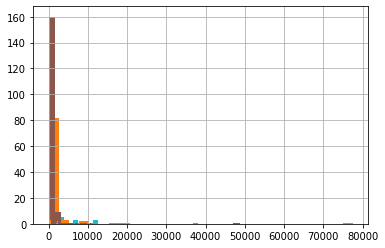

In [18]:
# Manually extracted source, which were pre-processed
manually_extracted_sources = crba_data_dictionary_source[crba_data_dictionary_source.REQUIRE_STAGING == 'Yes'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop 
manually_extracted_sources = manually_extracted_sources[
(manually_extracted_sources["SOURCE_ID"] != 'S-168') & 
(manually_extracted_sources["SOURCE_ID"] != 'S-169') &
(manually_extracted_sources["SOURCE_ID"] != 'S-170') #&
#(manually_extracted_sources["SOURCE_ID"] == 'S-230')
] 

#print(f"this is the dataframe: {manually_extracted_sources}")

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in manually_extracted_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    dataframe = pd.read_csv(
        data_sources_staged_raw
        / (row["SOURCE_ID"] + "_staged_raw.csv"),
        sep = ';'
    )

    # Save raw data (as actual raw, rather than staged raw data)
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    """# Cleansing
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )"""

    # print(dataframe)
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )
    
    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    #print(f"\n \n  the indicator name print is: \n {row['INDICATOR_NAME_x']} \n \n - - - - - - - - - - \n")

    #print(f"\n \n  the type is: \n {type(row['INDICATOR_NAME_x'])} \n \n - - - - - - - - - - \n")
    

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    #print(dataframe.RAW_OBS_VALUE.describe())

    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        log_info = True
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

#### Treaty data pipeline

This pipeline is identical to HTML-Sources: UN Treaties data. It concerns sources S-168, S-169 and S-170

In [19]:
# Manually extracted source, which were pre-processed
manually_extracted_sources = crba_data_dictionary_source[crba_data_dictionary_source.REQUIRE_STAGING == 'Yes'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop 
manually_extracted_sources = manually_extracted_sources[(manually_extracted_sources["SOURCE_ID"] == 'S-168') | 
(manually_extracted_sources["SOURCE_ID"] == 'S-169') |
(manually_extracted_sources["SOURCE_ID"] == 'S-170') 
] 

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in manually_extracted_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    dataframe = pd.read_csv(
        data_sources_staged_raw
        / (row["SOURCE_ID"] + "_staged_raw.csv"),
        sep = ';'
    )

    # Save raw data (as actual raw, rather than staged raw data)
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )    
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    # UN Treaty data specific: Sometimes, countries have footnotes (numbers). These must be purged for the rest of the code to work properly
    #dataframe['COUNTRY_NAME'] = dataframe['COUNTRY_NAME'].apply(lambda x: re.sub('\s\d+.*', '', x)) # delete everything after number (and the leading whitespace)

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_y"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"],
        attribute_unit_string=row["UNIT_MEASURE"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body = row["SOURCE_BODY"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        log_info=True
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["INDICATOR_ID"] + '_' + row["SOURCE_ID"] + '_' +row["INDICATOR_CODE"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-168 


 - - - - - 
 Cleansing source S-168 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 Calling function 'scaler'... 


 - - - - - 
 Extracting source S-169 


 - - - - - 
 Cleansing source S-169 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information 

## Concatenate all dataframes

In [11]:
# define emty dataframe
combined_normalized_csv = pd.DataFrame()

# Iterate through all files
for file in data_sources_normalized.iterdir():
    try:
        print(file)
        dataframe = pd.read_csv(
                file,
                sep = ';'
            )

        # print(dataframe)

        dataframe['INTERNAL_SOURCE_ID'] = file
        
        combined_normalized_csv = combined_normalized_csv.append(
            other = dataframe
        )
    except:
        print('didnt read file')
        print(file)

# Idenify all dimension columns in combined dataframe
available_dim_cols = []
for col in combined_normalized_csv.columns:
    dim_col = re.findall("DIM_.+", col)
    # print(dim_col)
    if len(dim_col) == 1:
        available_dim_cols += dim_col

# Fill _T for all NA values of dimension columns
combined_normalized_csv[available_dim_cols] = combined_normalized_csv[
    available_dim_cols
].fillna(value="_T")

# Double check if there are duplicate countries
print("This is the number of duplicate rows:")
print(sum(combined_normalized_csv.duplicated()))
print(combined_normalized_csv.loc[combined_normalized_csv.duplicated(), ['COUNTRY_ISO_3','INDICATOR_NAME', 'INDICATOR_CODE']])
#combined_normalized_csv = combined_normalized_csv.drop_duplicates() # uncomment if want to delete duplicates (but check where they come from first)

# Check that all indicators have been processed
assert crba_data_dictionary_snapshot.shape[0] == len(combined_normalized_csv.INDICATOR_CODE.unique())

data_out/data_normalized/I-100_S-119_MP_OL_LF_ISRECS_normalized.csv
data_out/data_normalized/I-101_S-120_MP_OL_LF_CSAELF_normalized.csv
data_out/data_normalized/I-102_S-121_MP_OL_LF_ONEXAB_normalized.csv
data_out/data_normalized/I-103_S-122_MP_OL_LF_DAPRPR_normalized.csv
data_out/data_normalized/I-104_S-123_MP_OL_OC_RESMEC_normalized.csv
data_out/data_normalized/I-105_S-124_MP_OL_EN_CHSAEE_normalized.csv
data_out/data_normalized/I-106_S-125_MP_OL_OC_PRSEVI_normalized.csv
data_out/data_normalized/I-107_S-126_MP_OL_OC_FREBUL_normalized.csv
data_out/data_normalized/I-109_S-128_MP_OL_EN_ENECRF_normalized.csv
data_out/data_normalized/I-10_S-10_WP_CL_LF_COMSCH_normalized.csv
data_out/data_normalized/I-110_S-129_MP_MA_EN_GOVEFF_normalized.csv
data_out/data_normalized/I-111_S-130_MP_PS_EN_GOVCOR_normalized.csv
data_out/data_normalized/I-112_S-131_MP_OL_EN_EFJUSY_normalized.csv
data_out/data_normalized/I-114_S-134_MP_OL_EN_CSAEGC_normalized.csv
data_out/data_normalized/I-115_S-135_MP_MA_EN_OPPO

In [12]:
# Export combined dataset
combined_normalized_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'combined_normalized.csv',
    sep = ";"
)

## Add aggregated scores

The following bit adds the aggregated scores to the final dataset. There are several approaches to creating aggregate scores.

The following implements the same aggregation methodology as for the CRBA 2018. That is, we introduce three aggregation levels: 

1. *Level 1:* Category-issue score (the average of all indicator scores pertaining to a given category and issue)
2. *Level 2:* Issue score (the average of all category-issue scores)
3. *Level 3:* Index score (the average of all issue scores in a given index)

This aggregation is done sequentelly as outlined above. 

Furthermore, a weighting is applied, to give more importance to outcome and enforcement indicators. This weighting is implemented by duplicating those level 1 category-issue scores of category "outcome" or "enforcement", before computing level 2 scores. 

In [13]:
# Create category score
aggregated_scores_dataset = combined_normalized_csv.loc[
    combined_normalized_csv['COUNTRY_ISO_3'] != 'XKX', 
    [
        'COUNTRY_ISO_3',
        'SCALED_OBS_VALUE',
        'INDICATOR_INDEX',
        'INDICATOR_ISSUE',
        'INDICATOR_CATEGORY'
    ]
].groupby(
    by = [
        'COUNTRY_ISO_3',
        'INDICATOR_CATEGORY', 
        'INDICATOR_ISSUE',
        'INDICATOR_INDEX'
    ],
    as_index = False
).mean().rename(
    columns={
        'SCALED_OBS_VALUE' : 'CATEGORY_ISSUE_SCORE'
    }
)

# # # # Introduce weighting: duplicate all index_issues who belong to category outcome or enforcement
aggregated_scores_dataset = aggregated_scores_dataset.append(
    aggregated_scores_dataset.loc[
        (aggregated_scores_dataset['INDICATOR_CATEGORY'] == 'Outcome') |
        (aggregated_scores_dataset['INDICATOR_CATEGORY'] == 'Enforcement')
    ]
)

# # # # # # # Issue score
temp = aggregated_scores_dataset.groupby(
    by = [
        'COUNTRY_ISO_3',
        'INDICATOR_ISSUE',
        'INDICATOR_INDEX'
    ],
    as_index = False
).mean().rename(
    columns={
        'CATEGORY_ISSUE_SCORE' : 'ISSUE_INDEX_SCORE'
    }
)

# Drop duplicates again
temp = temp.drop_duplicates()

# # Add risk category
# Define list of percentiles
percentile_33 = temp[
    'ISSUE_INDEX_SCORE'
].quantile(
    0.333
)

percentile_66 = temp[
    'ISSUE_INDEX_SCORE'
].quantile(
    0.667
)

# Add column indicating risk category
temp.loc[
    temp['ISSUE_INDEX_SCORE'] < percentile_33,
    'ISSUE_INDEX_RISK_CATEGORY'
    ] = 'High risk' 

temp.loc[
    temp['ISSUE_INDEX_SCORE'] > percentile_66,
    'ISSUE_INDEX_RISK_CATEGORY'
    ] = 'Low risk'

temp.loc[
    (temp['ISSUE_INDEX_SCORE'] > percentile_33) & 
    (temp['ISSUE_INDEX_SCORE'] < percentile_66),
    'ISSUE_INDEX_RISK_CATEGORY'
    ] = 'Medium risk'



# # # # # #  Index score
temp_2 = temp.groupby(
    by = [
        'COUNTRY_ISO_3',
        'INDICATOR_INDEX'
    ],
    as_index = False
).mean().rename(
    columns={
        'ISSUE_INDEX_SCORE' : 'INDEX_SCORE'
    }
)

# # Add risk category
# Define list of percentiles
percentile_33 = temp_2[
    'INDEX_SCORE'
].quantile(
    0.333
)

percentile_66 = temp_2[
    'INDEX_SCORE'
].quantile(
    0.667
)

# Add column indicating risk category
temp_2.loc[
    temp_2['INDEX_SCORE'] < percentile_33,
    'INDEX_RISK_CATEGORY'
    ] = 'High risk' 

temp_2.loc[
    temp_2['INDEX_SCORE'] > percentile_66,
    'INDEX_RISK_CATEGORY'
    ] = 'Low risk'

temp_2.loc[
    (temp_2['INDEX_SCORE'] > percentile_33) & 
    (temp_2['INDEX_SCORE'] < percentile_66),
    'INDEX_RISK_CATEGORY'
    ] = 'Medium risk'





# # # # # Overall score
temp_3 = temp_2.groupby(
    by = [
        'COUNTRY_ISO_3',
    ],
    as_index = False
).mean().rename(
    columns={
        'INDEX_SCORE' : 'OVERALL_SCORE'
    }
)

# Join all aggregated score together
aggregated_scores_dataset = aggregated_scores_dataset.merge(
    right = temp,
    on = [
        'COUNTRY_ISO_3',
        'INDICATOR_ISSUE',
        'INDICATOR_INDEX',
    ]
).merge(
    right = temp_2,
    on = [
        'COUNTRY_ISO_3',
        'INDICATOR_INDEX'
    ]
).merge(
    right = temp_3,
    on = [
        'COUNTRY_ISO_3',
    ]
).merge(
    right = country_crba_list,
    on = 'COUNTRY_ISO_3'
).drop(
    [
        'COUNTRY_NAME',
        'COUNTRY_ISO_2'
    ],
    axis=1
)

In [14]:
# Join sores to original dataset
crba_final = combined_normalized_csv.merge(
    right=aggregated_scores_dataset,
    on=[
        'COUNTRY_ISO_3',
        'INDICATOR_CATEGORY',
        'INDICATOR_ISSUE',
        'INDICATOR_INDEX'
    ],
    how='left' 
)

# Did not join on entire composite key on left, must drop dupliates
crba_final = crba_final.drop_duplicates()

### Export final, combined dataframe

In [15]:
# Export combined cleansed dataframe as a sample
crba_final.to_csv(
    path_or_buf = cwd / 'data_out' / 'crba_final.csv',
    sep = ";",
    index=False
)
    
aggregated_scores_dataset.to_csv(
    path_or_buf = validation_and_analysis / 'aggregated_scores.csv',
    sep = ";"
)

## Postprocessing of final file to bring it into SDMX format

The file 'crba_final.csv' is comprehensive. It contains all relevant data, including metadata. Some of this information is superfluous and should not be inluded in the file 

In [18]:
# Read final dataframe
crba_final = pd.read_csv(
    cwd / 'data_out' / 'crba_final.csv',
    sep = ";"
)

# Discard unnecessary rows (i.e. in order to discard DIM_ELEMENT_TYPE limit ourselves to relevant subdimension group, then discard of column altogether)
crba_final = crba_final.loc[
    (crba_final['DIM_ELEMENT_TYPE'] == '_T') |
    (crba_final['DIM_ELEMENT_TYPE'] == '2017 RESOURCE GOVERNANCE INDEX')  
]

# Define list of columns to drop
dropped_cols = [
    'Unnamed: 0',
    '_merge',
    'COUNTRY_ISO_2',
    'COUNTRY_NAME',
    'DIM_REP_TYPE',
    'DIM_ELEMENT_TYPE',
    'ATTR_INDICATOR_DESCRIPTION', 
    'ATTR_INDICATOR_EXPLANATION', 
    'ATTR_DATA_EXTRACTION_METHDOLOGY', 
    'ATTR_SOURCE_TITLE', 
    'ATTR_SDG_INDICATOR_DESCRIPTION', 
    'ATTR_SOURCE_OF_SOURCE', 
    'ATTR_FOOTNOTE_OF_SOURCE',
    'INTERNAL_SOURCE_ID'
]

# Drop columns
crba_final_sdmx_ready = crba_final.drop(
    labels=dropped_cols,
    axis=1
) 

# Map values to encode them as SDMX codes 
# Run the column mapper script to load the mapping dictionary
with open(data_in / 'value_mapping_sdmx_encoding.py') as file:
    exec(file.read())

crba_final_sdmx_ready = cleanse.Cleanser().map_values(
    cleansed_data = crba_final_sdmx_ready,
    value_mapping_dict = value_mapper_sdmx_encoding
)


# FSM has duplicate entry for four indicators (scoring was only done for one of them), drop rows that haven't been scored
sdmx_df_columns_dims = [
    "INDICATOR_CODE",
    "COUNTRY_ISO_3",
    "TIME_PERIOD",
    "DIM_SEX",
    "DIM_EDU_LEVEL",
    "DIM_AGE_GROUP",
    "DIM_MANAGEMENT_LEVEL",
    "DIM_AREA_TYPE",
    "DIM_QUANTILE",
    "DIM_SDG_INDICATOR",
    "DIM_OCU_TYPE",
    "DIM_SECTOR",
    "DIM_ALCOHOL_TYPE",
    "DIM_CAUSE_TYPE",
    "DIM_MATERNAL_EDU_LVL",
]

crba_final_sdmx_ready = crba_final_sdmx_ready.loc[~(crba_final_sdmx_ready.duplicated(
    subset = sdmx_df_columns_dims,
    keep=False
)) | ~(crba_final_sdmx_ready['SCALED_OBS_VALUE'].isna()), : ]

# Add dataflow column, TO DO: Adjust if necessary
crba_final_sdmx_ready['DATAFLOW'] = 'PFP:CRBA(1.0)'


 Calling function 'map_values'...

 Successfully mapped values of column: INDICATOR_INDEX

 Successfully mapped values of column: INDICATOR_ISSUE

 Successfully mapped values of column: INDICATOR_CATEGORY

 Successfully mapped values of column: DIM_AGE_GROUP

 Successfully mapped values of column: DIM_SEX

 Successfully mapped values of column: DIM_SECTOR

 Successfully mapped values of column: DIM_AREA_TYPE

 Successfully mapped values of column: DIM_EDU_LEVEL

 Successfully mapped values of column: DIM_MATERNAL_EDU_LVL

 Successfully mapped values of column: DIM_QUANTILE

 Successfully mapped values of column: DIM_OCU_TYPE

 Successfully mapped values of column: DIM_CAUSE_TYPE

 Successfully mapped values of column: DIM_MANAGEMENT_LEVEL


In [19]:
# Save sdmx ready file
crba_final_sdmx_ready.to_csv(
    path_or_buf = cwd / 'data_out' / 'crba_final_sdmx_ready.csv',
    sep = ";",
    index=False
)

**End of file**